# Skincancer HAM-dataset med Pytorch

In [1]:
do_training = True

## Standardimporter

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
import torch.optim as optim
from torch.optim import lr_scheduler

import time
import os

import numpy as np
import pandas as pd
#from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

## Hantering av GPU och CPU:

In [3]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [4]:
device = get_default_device()

In [5]:
# print(device)

### De båda nedanstående blocken används för att enkelt flytta till GPU: 

In [6]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [7]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

## Hjälpfunktioner för att spara och ladda:

In [8]:
# Anropas när följande variabler finns tillgängliga:
# epochs, batchsz-{train, val}, learning_rate
# Dessa krävs för funktionen "create_filename".

def create_filename(filename):
    global file_name
    file_name = filename + "_e" + str(epochs) + "_bsztr" + str(batchsz_train) + \
            "_bszval" + str(batchsz_val) + "_lr" + str(f'{learning_rate:.0e}')
    return file_name

In [9]:
# https://pytorch.org/docs/master/notes/serialization.html

def save_trained_model(modelname):
    model_folder = "trained_models"
    model_file_suffix = ".pt"
    create_filename(modelname) # spottar ur sig ett filnamn i variabeln "file_name"
    
    full_model_filename = model_folder + "/" + file_name + model_file_suffix
    
    torch.save(model.state_dict(), full_model_filename)

In [10]:
def load_trained_model(modelname):
    model_folder = "trained_models"
    model_file_suffix = ".pt"
    create_filename(modelname) # spottar ur sig ett filnamn i variabeln "file_name"
    
    full_model_filename = model_folder + "/" + file_name + model_file_suffix
    
    if torch.cuda.is_available():
        model.load_state_dict(torch.load(full_model_filename))
    else:
        model.load_state_dict(torch.load(full_model_filename, map_location=torch.device('cpu')))

In [11]:
def save_training_log(logname, do_validation = True):
    log_folder = "logs"
    log_filename = create_filename(logname)
    log_file_suffix = ".csv"
    full_log_filename = log_folder + "/" + file_name + log_file_suffix
        
    global training_log
        
    # Speciell range nedan för att starta på epok 1 och ej 0:
    if do_validation == True:
        training_log = pd.DataFrame(data={"epoch": range(1, epochs + 1), \
                                              "train_acc": train_accuracy, \
                                              "train_loss": train_losses,  \
                                              "val_acc": val_accuracy, \
                                              "val_loss": val_losses})
    
        training_log.to_csv(full_log_filename, sep=',', index = False)
        
    else:
        training_log = pd.DataFrame(data={"epoch": range(1, epochs + 1), \
                                              "train_acc": train_accuracy, \
                                              "train_loss": train_losses})
    
        training_log.to_csv(full_log_filename, sep=',', index = False)
    
    return training_log

In [12]:
def load_training_log(logname):
    log_folder = "logs"
    log_filename = create_filename(logname)
    log_file_suffix = ".csv"
    full_log_filename = log_folder + "/" + file_name + log_file_suffix
    
    global training_log
    training_log = pd.read_csv(full_log_filename)
    return training_log

## Definiera de olika mängderna för träning, validering och test:

In [13]:
epochs = 100
learning_rate = 1e-4

img_w = 299
img_h = 299
img_dim = 3

batchsz_train = 2**2
batchsz_val = 2**4
batchsz_test = 2**4

train_num_workers = 4
test_val_num_workers = 4

basepath = "../../../ml/Datasets/skin-cancer-mnist-ham10000/images_per_label_splitted_sets/"

In [14]:
# Definiera vilken augmentation som ska göras:
train_data_transform = transforms.Compose([
        transforms.RandomResizedCrop(img_w),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

val_test_data_transform = transforms.Compose([
        transforms.RandomResizedCrop(img_w),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

In [15]:
# Definiera de tre dataseten:
skincancer_train_dataset = datasets.ImageFolder(root = basepath + 'train/',
                                           transform = train_data_transform)

skincancer_valid_dataset = datasets.ImageFolder(root = basepath + 'val/',
                                           transform = val_test_data_transform)

skincancer_test_dataset = datasets.ImageFolder(root = basepath + 'test/',
                                              transform = val_test_data_transform)

In [16]:
# Skapa loaders för de tre dataseten:
train_loader = torch.utils.data.DataLoader(skincancer_train_dataset,
                                             batch_size = batchsz_train, 
                                             shuffle = True,
                                             pin_memory = True,
                                             drop_last = True,
                                             num_workers = train_num_workers)

valid_loader = torch.utils.data.DataLoader(skincancer_valid_dataset,
                                             batch_size = batchsz_val, 
                                             shuffle = True,
                                             num_workers = test_val_num_workers)

test_loader = torch.utils.data.DataLoader(skincancer_test_dataset,
                                             batch_size = batchsz_test, 
                                             shuffle = False,
                                             num_workers = test_val_num_workers)

### Skapa en weighted loader som hanterar obalansen mellan klasserna:

In [17]:
train_targets = train_loader.dataset.targets
# print(len(train_targets))

In [18]:
from torch.utils.data import WeightedRandomSampler

In [19]:
# Test för att oversampla vissa klasser...
# https://discuss.pytorch.org/t/how-to-implement-oversampling-in-cifar-10/16964/6

train_targets = train_loader.dataset.targets
class_count = np.unique(train_targets, return_counts=True)[1]
#print("Antal bilder per klass = ", class_count, "\n")

# Testa att köra med 1 / sevenones för att se en obalanserad, vanlig, loader
# och med 1 / class_count för att se hur det balanserade resultatet blir:

# sevenones = np.ones(7)
# weight = 1 / sevenones
weight = 1. / class_count
samples_weight = weight[train_targets]
samples_weight = torch.from_numpy(samples_weight)

# Replacement = True ger dragning med återläggning, vilket vi ska ha, 
# annars kommer de mindre klasserna "ta slut" i dragningen:
sampler = WeightedRandomSampler(samples_weight, len(samples_weight), replacement=True)

In [20]:
# Skapa en ny dataloader baserad på 
# träningssetet som är viktad klassivs:

# "pin_memory=True" gör att man flyttar data till GPU:n medan 
# vi kör träningen, vilket påskyndar arbetet radikalt, ffa
# om vi har komplexa modeller.
train_loader_weighted = DataLoader(skincancer_train_dataset, 
                             batch_size = batchsz_train, 
                             sampler = sampler, # kan ej ha shuffle = True med sampler!
                             pin_memory=True,
                             drop_last=True,
                             num_workers = train_num_workers)

In [21]:
# Definiera antalet klasser:

number_of_classes = len(test_loader.dataset.classes)

### Flytta *_loader till rätt device

In [22]:
train_dl = DeviceDataLoader(train_loader, device)
train_dl_weighted = DeviceDataLoader(train_loader_weighted, device)
valid_dl = DeviceDataLoader(valid_loader, device)
test_dl = DeviceDataLoader(test_loader, device)

### Visa skillnader mellan oviktad och viktad loader:

In [49]:
print("Antal bilder per klass = ", class_count, "\n")

# Visa hur den drar samples från klasserna för fyra batcher:
for batch_idx, (data, target) in enumerate(train_loader_weighted):
    print('Batch {}, classes {}, count {}'.format(
        batch_idx, *np.unique(target.numpy(), return_counts=True)))
    if batch_idx == 3:
        break

Antal bilder per klass =  [ 228  359  769   80  779 4693   99] 

Batch 0, classes [2 5 6], count [1 1 2]
Batch 1, classes [0 2 5 6], count [1 1 1 1]
Batch 2, classes [0 4], count [2 2]
Batch 3, classes [0 3 4], count [1 2 1]


In [50]:
print("Antal bilder per klass = ", class_count, "\n")

# Visa hur den drar samples från klasserna för fyra batcher:
for batch_idx, (data, target) in enumerate(train_loader):
    print('Batch {}, classes {}, count {}'.format(
        batch_idx, *np.unique(target.numpy(), return_counts=True)))
    if batch_idx == 3:
        break

Antal bilder per klass =  [ 228  359  769   80  779 4693   99] 

Batch 0, classes [1 5], count [1 3]
Batch 1, classes [5], count [4]
Batch 2, classes [1 5], count [1 3]
Batch 3, classes [0 1 4 5], count [1 1 1 1]


In [51]:
# len(target) # ger en vektor med batchsz i storlek.

# Kolla t.ex. hur många samples ur klass A som finns i sista batchen ovan:
# A = 0
# np.sum(target.numpy() == A)

In [52]:
# Visa dimensionerna för en bild-tensor (batchsize, number of channels, width, height):
# images.shape

## Definiera en modell:

In [23]:
# Instansiera en modell:

model = models.inception_v3(pretrained = True, progress = True)

In [24]:
# Printa modellen för att se de sista FC-lagren som behöver bytas ut: 
print(model)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, t

In [25]:
models_last_fc_infeatures = 2048
model_name = 'Inception_v3'

In [26]:
create_filename(model_name)

'Inception_v3_e100_bsztr4_bszval16_lr1e-04'

In [27]:
if do_training == True:
    
    # Vi måste ändra på det sista FC-lagret i modellen, som från början
    # innehållet 1000 st out-features. Vi behöver bara 7.

    for param in model.parameters():
        param.require_grad = False
    
    # Ersätt sista fc-lagret med rätt antal ut-klasser: 
    model.fc = nn.Linear(in_features = models_last_fc_infeatures, out_features = number_of_classes, bias = True)
    
else:
    model.fc = nn.Linear(in_features = models_last_fc_infeatures, out_features = number_of_classes, bias = True)
    load_trained_model(model_name)
    model.eval()

### Flytta modellen till GPU, om en sådan finns:

In [28]:
# Flytta modellen till rätt device:

to_device(model, device)

# Verifiera att modellen är på rätt device:
# True => modellen finns på GPU.

next(model.parameters()).is_cuda

True

In [29]:
trainableparameters = []
for param in model.parameters():
    # trainableparameters = param.numel()
    trainableparameters.append(param.numel())
    num_trainable_params = np.sum(trainableparameters)
    
print(f'Antalet träningsbara parametrar är {num_trainable_params:,} st.')

Antalet träningsbara parametrar är 25,126,607 st.


## Definiera loss-function och vilken metod för optimering som ska användas:

In [30]:
# Definiera loss-function och vilken optimerare som ska användas:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [31]:
# Decay LR by a factor of 0.1 every 3 epochs
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size = 3, gamma = 0.1)

## Följande återställer modellens vikter mellan olika körningar

In [32]:
def weights_init(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_uniform_(m.weight.data)

## Overfit på en batch för att se att modellen är rimlig

In [34]:
if do_training == True:

    model.apply(weights_init)
    model.train()

    inputs, labels = next(iter(train_dl_weighted))
    inputs = inputs.to(device)
    labels = labels.to(device)

    criterion_check_onebatch = nn.CrossEntropyLoss()
    optimizer_check_onebatch = optim.Adam(model.parameters(), lr = learning_rate)

    model.train()
    for epoch in range(31):
        optimizer_check_onebatch.zero_grad()
        outputs = model(inputs)
        loss = criterion_check_onebatch(outputs, labels)
        _, preds = torch.max(outputs, 1)
        loss.backward()
        optimizer_check_onebatch.step()
        correct = torch.sum(preds == labels)
    
        if epoch%10 == 0:
            print(f'Epok {epoch:02}: ----- loss = {loss:4.4f} ----- accuracy = {correct}')
else:
    pass

# Träna och utvärdera modellen

In [140]:
def train_eval(epochs = 10, do_validation = True, training_dataloader = train_dl_weighted, validation_dataloader = valid_dl):

    # if ((do_training == False) and (do_validation == True)):
    #    print("Kan inte validera en modell som inte tränats.")
    # else:
    start_training_time = time.time()

    # Placeholders för att mäta modellen:
    global train_accuracy, train_losses, val_accuracy, val_losses
        
    train_accuracy = []
    train_losses = []
        
    val_accuracy = []
    val_losses = []

    for epoch in range(epochs):
        start_epoch_time = time.time()
        train_correct_pred_per_epoch = 0
        
        current_train_loss = 0.0
        current_train_corrects = 0
        
        # Träning ###########################################################
        # Sätt modellen i träningsläge:
        start_train_time = time.time()
        model.train()
        
        for inputs_train, labels_train in training_dataloader:
            # Med denna modell får vi två outputs:
            train_predictions, train_aux_logits = model.forward(inputs_train)
            optimizer.zero_grad()
            
            train_loss = criterion(train_predictions, labels_train)
            train_loss.backward()
                
            optimizer.step()
                    
            #exp_lr_scheduler.step()
            #lr = exp_lr_scheduler.get_lr()
                
            # Nedan ger den mest troliga klassen:
            # train_predicted består av två värden:
            # values och indices, därav väljer 
            # vi train_predicted[1] sen.
            train_predicted = torch.max(train_predictions, 1)
    
            current_train_loss += train_loss.item() * batchsz_train
            current_train_corrects += torch.sum(train_predicted[1] == labels_train.data)
        
        end_train_time = time.time()
        
        # Validering ########################################################
        # Sätt modellen i utvärderingsläge:
            
        if do_validation == True:
            start_eval_time = time.time()
            model.eval()
        
            current_val_loss = 0.0
            current_val_corrects = 0
        
            with torch.no_grad():
                
                inputs_val, labels_val = next(iter(validation_dataloader))
                
                val_predictions = model.forward(inputs_val)
                val_loss = criterion(val_predictions, labels_val)
                
                val_pred_values, val_predicted = torch.max(val_predictions, 1)
                    
                current_val_loss += val_loss.item() * batchsz_val
                current_val_corrects += torch.sum(val_predicted == labels_val.data)
        
            end_eval_time = time.time()
        else:
            pass
            
        ######################################################################
        
        # Metrics ############################################################
        # Räkna ut acc och loss per epok:
        epoch_train_loss = np.float64(current_train_loss / num_train_images)
        epoch_train_acc = np.float64(current_train_corrects.double() / num_train_images)
        
        if do_validation == True:
            epoch_val_loss = np.float64(current_val_loss / batchsz_val)
            epoch_val_acc = np.float64(current_val_corrects.double() / batchsz_val)
        else:
            pass
                
        # Lagra accuracy och loss per epok i en lista för t.ex. plottning:
        train_losses.append(epoch_train_loss)
        train_accuracy.append(epoch_train_acc)
            
        if do_validation == True:
            val_losses.append(epoch_val_loss)
            val_accuracy.append(epoch_val_acc)
        else:
            pass
                
        # Räkna ut tiderna per epok:
        end_epoch_time = time.time()
        epoch_time = end_epoch_time - start_epoch_time
        
        # epoch startar på 0, därav "+1" nedan:
        if do_validation == True:
            print(f"Epok {epoch + 1:02}: {epoch_time:2.1f} sek, train-acc = {epoch_train_acc:4.3f}, val-acc = {epoch_val_acc:4.3f}, train-loss = {epoch_train_loss:4.4f}, val-loss = {epoch_val_loss:4.4f}")            
        else:
            print(f"Epok {epoch + 1:02}: {epoch_time:2.1f} sek, train-acc = {epoch_train_acc:4.3f}, train-loss = {epoch_train_loss:4.4f}")
    
    # Spara träningsdatan till fil och i en pandas_df:
    #save_training_log(model_name, do_validation)
    
    end_training_time = time.time()
    
    delta = end_training_time - start_training_time
    
    print(f'\nTraining took {delta:.2f} seconds.')

In [ ]:
# Felsökning nedan... :-)

In [102]:
with torch.no_grad():
    inputs_val, labels_val = next(iter(valid_dl))
                
    val_predictions = model.forward(inputs_val)
    val_loss = criterion(val_predictions, labels_val)
                
    val_pred_values, val_predicted = torch.max(val_predictions, 1)
    current_val_corrects = 0

    current_val_corrects += torch.sum(val_predicted == labels_val.data)
    print(current_val_corrects)

tensor(8, device='cuda:0')


In [90]:
val_predictions # (16, 7), från model.forward(inputs)
# Är detta "sannolikheten" per klass, crossentropy? Ja, eftersom det 
# kommer från model.forward()...!

tensor([[-0.5186, -0.0426, -0.4392, -0.1860, -0.2805, -0.8589,  0.0593],
        [ 0.3928, -0.2779, -0.1446,  0.3555, -0.4682,  0.2508, -0.1850],
        [-0.5906, -0.4043,  0.1135,  0.1581,  0.0968, -0.1123, -0.3515],
        [ 0.3514,  0.1627,  0.3748, -0.1686,  0.1726,  0.1787,  0.5258],
        [-0.0804, -0.1824, -0.3288, -0.1269,  0.1130,  0.1983, -0.2513],
        [ 0.2773, -0.6002, -0.1763, -0.0763,  0.3227, -0.2346, -0.5133],
        [-0.0805, -0.3232,  0.0648, -0.0875,  0.0601, -0.0177,  0.2190],
        [-0.3279, -0.2118,  0.1383, -0.2011,  0.0932, -0.0749, -0.1768],
        [-0.3830, -0.5163,  0.2566, -0.0472,  0.1888,  0.0033, -0.3669],
        [-0.0913, -0.0355, -0.0042, -0.5512,  0.3089, -0.6105, -0.0823],
        [-0.1353, -0.5246,  0.2645, -0.5012,  0.0816,  0.2328, -0.1560],
        [ 0.4153, -0.1650,  0.3160,  0.2189, -0.1188,  0.1177, -0.1486],
        [-0.0165, -0.5099, -0.1494,  0.6054,  0.1635,  0.0330, -0.1733],
        [-0.4773,  0.0527, -0.0618,  0.2371, -0.161

In [91]:
val_what # (16, 1000), från model.forward(inputs)

tensor([[-0.2042, -0.3192, -1.8778,  ...,  0.3699, -1.3243, -0.1011],
        [-0.8045,  1.1339, -2.7234,  ...,  0.8253,  1.9302,  1.8388],
        [-1.5712,  1.3545, -0.6361,  ..., -3.8614,  0.2421,  0.8606],
        ...,
        [-0.9931,  1.2717, -0.4980,  ...,  1.9029,  3.0866,  0.6406],
        [-0.6393,  2.0526,  0.9540,  ..., -0.3114, -0.8450,  0.7645],
        [ 0.2048,  0.4666,  1.8012,  ...,  0.4212,  1.1100, -3.0695]],
       device='cuda:0')

In [92]:
val_pred_values # (16), torch.max(val_predictions, 1)
# torch.max(tensor, dim = 1) ger två värden:
# 1. max-värdena längs dim = 1 (=rad)
# 2. max-värdenas index i tensorn.

# Men varför en 1000-dimensions-tensor ovan?

tensor([0.0593, 0.3928, 0.1581, 0.5258, 0.1983, 0.3227, 0.2190, 0.1383, 0.2566,
        0.3089, 0.2645, 0.4153, 0.6054, 0.2371, 0.3729, 0.2361],
       device='cuda:0')

In [93]:
val_predicted # (16), torch.max(val_predictions, 1)

tensor([6, 0, 3, 6, 5, 4, 6, 2, 2, 4, 2, 0, 3, 3, 4, 0], device='cuda:0')

In [ ]:
# slut på felsökning i validation!

In [108]:
# Nollställer vikterna i modellen:
if do_training == True:
    model.apply(weights_init)
else:
    pass

# Nedan för att vi använder "droplast = True"...

# Train:
num_train_images = batchsz_train * np.floor_divide(len(train_loader.dataset), batchsz_train)
    
# Validation:
num_val_images = batchsz_val * np.floor_divide(len(valid_loader.dataset), batchsz_val)

### Träningsrunda #1

In [114]:
# Här görs själva träningen, valideringen, sparande av modellen och träningsloggen.
# Alternativt så laddas en redan färdig modell/träningslogg.

# "epochs" definieras i början av filen!

if do_training == True:
    train_eval(epochs, do_validation=True, training_dataloader=train_dl_weighted, validation_dataloader=valid_dl)
    save_trained_model(model_name)
else:
    load_training_log(model_name)

Epok 01: 188.7 sek, train-acc = 0.153, val-acc = 0.188, train-loss = 1.9475, val-loss = 2.0978
Epok 02: 195.5 sek, train-acc = 0.201, val-acc = 0.312, train-loss = 1.8938, val-loss = 1.6088
Epok 03: 195.3 sek, train-acc = 0.252, val-acc = 0.062, train-loss = 1.8310, val-loss = 2.1506
Epok 04: 195.2 sek, train-acc = 0.293, val-acc = 0.250, train-loss = 1.7670, val-loss = 1.5951
Epok 05: 196.0 sek, train-acc = 0.348, val-acc = 0.375, train-loss = 1.6789, val-loss = 1.9975
Epok 06: 197.8 sek, train-acc = 0.373, val-acc = 0.562, train-loss = 1.6287, val-loss = 1.1916
Epok 07: 197.9 sek, train-acc = 0.399, val-acc = 0.375, train-loss = 1.5708, val-loss = 1.4248
Epok 08: 198.3 sek, train-acc = 0.411, val-acc = 0.250, train-loss = 1.5293, val-loss = 1.9929
Epok 09: 198.6 sek, train-acc = 0.439, val-acc = 0.500, train-loss = 1.4731, val-loss = 1.3103
Epok 10: 197.0 sek, train-acc = 0.440, val-acc = 0.375, train-loss = 1.4743, val-loss = 1.3613
Epok 11: 196.5 sek, train-acc = 0.472, val-acc = 0

Epok 88: 198.2 sek, train-acc = 0.775, val-acc = 0.500, train-loss = 0.6023, val-loss = 1.5081
Epok 89: 198.0 sek, train-acc = 0.784, val-acc = 0.625, train-loss = 0.5808, val-loss = 0.9736
Epok 90: 198.0 sek, train-acc = 0.780, val-acc = 0.875, train-loss = 0.5995, val-loss = 0.5954
Epok 91: 198.0 sek, train-acc = 0.794, val-acc = 0.812, train-loss = 0.5641, val-loss = 0.4165
Epok 92: 198.1 sek, train-acc = 0.787, val-acc = 0.875, train-loss = 0.5645, val-loss = 0.5689
Epok 93: 198.2 sek, train-acc = 0.787, val-acc = 0.688, train-loss = 0.5892, val-loss = 0.7354
Epok 94: 198.1 sek, train-acc = 0.784, val-acc = 0.812, train-loss = 0.5901, val-loss = 0.8423
Epok 95: 198.3 sek, train-acc = 0.795, val-acc = 0.750, train-loss = 0.5705, val-loss = 1.3004
Epok 96: 198.1 sek, train-acc = 0.790, val-acc = 0.562, train-loss = 0.5711, val-loss = 1.0325
Epok 97: 198.3 sek, train-acc = 0.791, val-acc = 0.875, train-loss = 0.5681, val-loss = 0.5962
Epok 98: 198.3 sek, train-acc = 0.804, val-acc = 0

### Träningsrunda #2

In [142]:
# Träna igen med 1/10 lr:
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-5)

In [143]:
train_eval(epochs, do_validation=True, training_dataloader=train_dl_weighted, validation_dataloader=valid_dl)

Epok 01: 195.5 sek, train-acc = 0.807, val-acc = 0.562, train-loss = 0.5166, val-loss = 1.0817
Epok 02: 198.0 sek, train-acc = 0.825, val-acc = 0.625, train-loss = 0.4823, val-loss = 0.9798
Epok 03: 196.5 sek, train-acc = 0.840, val-acc = 0.562, train-loss = 0.4388, val-loss = 1.1893
Epok 04: 196.5 sek, train-acc = 0.835, val-acc = 0.750, train-loss = 0.4480, val-loss = 1.0340
Epok 05: 196.6 sek, train-acc = 0.829, val-acc = 0.688, train-loss = 0.4615, val-loss = 0.9008
Epok 06: 196.9 sek, train-acc = 0.843, val-acc = 0.812, train-loss = 0.4353, val-loss = 0.7824
Epok 07: 199.3 sek, train-acc = 0.839, val-acc = 0.750, train-loss = 0.4396, val-loss = 0.9192
Epok 08: 199.4 sek, train-acc = 0.833, val-acc = 0.938, train-loss = 0.4467, val-loss = 0.3198
Epok 09: 199.2 sek, train-acc = 0.842, val-acc = 0.625, train-loss = 0.4330, val-loss = 0.9602
Epok 10: 198.0 sek, train-acc = 0.842, val-acc = 0.812, train-loss = 0.4254, val-loss = 0.3324
Epok 11: 199.6 sek, train-acc = 0.846, val-acc = 0

Epok 88: 198.9 sek, train-acc = 0.871, val-acc = 0.812, train-loss = 0.3506, val-loss = 0.3547
Epok 89: 199.0 sek, train-acc = 0.878, val-acc = 0.750, train-loss = 0.3339, val-loss = 0.5044
Epok 90: 198.9 sek, train-acc = 0.879, val-acc = 0.688, train-loss = 0.3304, val-loss = 0.8986
Epok 91: 199.1 sek, train-acc = 0.879, val-acc = 0.875, train-loss = 0.3394, val-loss = 0.2694
Epok 92: 198.9 sek, train-acc = 0.879, val-acc = 0.688, train-loss = 0.3306, val-loss = 0.5232
Epok 93: 198.8 sek, train-acc = 0.873, val-acc = 0.812, train-loss = 0.3435, val-loss = 0.7928
Epok 94: 199.0 sek, train-acc = 0.883, val-acc = 0.688, train-loss = 0.3210, val-loss = 0.9696
Epok 95: 198.8 sek, train-acc = 0.884, val-acc = 0.875, train-loss = 0.3155, val-loss = 0.5224
Epok 96: 199.0 sek, train-acc = 0.868, val-acc = 0.688, train-loss = 0.3596, val-loss = 0.4225
Epok 97: 198.9 sek, train-acc = 0.881, val-acc = 0.750, train-loss = 0.3309, val-loss = 0.9740
Epok 98: 198.6 sek, train-acc = 0.877, val-acc = 0

In [144]:
save_trained_model(model_name)

In [145]:
save_training_log(model_name, True)

,epoch,train_acc,train_loss,val_acc,val_loss
0,1,0.807396,0.516601,0.5625,1.081673
1,2,0.825385,0.482347,0.6250,0.979839
2,3,0.839520,0.438792,0.5625,1.189287
3,4,0.835094,0.448042,0.7500,1.034017
4,5,0.828955,0.461532,0.6875,0.900803
...,...,...,...,...,...
95,96,0.868361,0.359616,0.6875,0.422541
96,97,0.881211,0.330864,0.7500,0.974005
97,98,0.877499,0.328972,0.8750,0.256247
98,99,0.878926,0.339228,0.5625,1.694368


In [ ]:
# Nedan celler för felsökning:

In [58]:
inputs, labels = next(iter(train_dl_weighted))
outputs, logits = model.forward(inputs)

In [60]:
train_loss = criterion(outputs, labels)

In [61]:
train_loss

tensor(1.9413, device='cuda:0', grad_fn=<NllLossBackward>)

In [65]:
train_loss.backward()
                
optimizer.step()
                    
train_predicted = torch.max(outputs, 1)

In [70]:
current_train_loss = 0.0
current_train_corrects = 0.0
current_train_loss += train_loss.item() * batchsz_train

In [72]:
labels.data

tensor([1, 2, 1, 0], device='cuda:0')

In [77]:
train_predicted

torch.return_types.max(
values=tensor([0.2186, 0.2908, 0.0897, 0.0519], device='cuda:0',
       grad_fn=<MaxBackward0>),
indices=tensor([3, 1, 5, 6], device='cuda:0'))

In [74]:
train_predicted[1]

tensor([3, 1, 5, 6], device='cuda:0')

In [75]:
current_train_corrects += torch.sum(train_predicted[1] == labels.data)

In [76]:
current_train_corrects

tensor(0., device='cuda:0')

In [121]:
training_log.head()

,epoch,train_acc,train_loss,val_acc,val_loss
0,1,0.152913,1.947532,0.1875,2.097773
1,2,0.200742,1.893778,0.3125,1.608780
2,3,0.252427,1.830984,0.0625,2.150602
3,4,0.292975,1.766962,0.2500,1.595148
4,5,0.347658,1.678864,0.3750,1.997504


## Utvärdering av modellen:

### Grafer över accuracy och loss på train/validation:

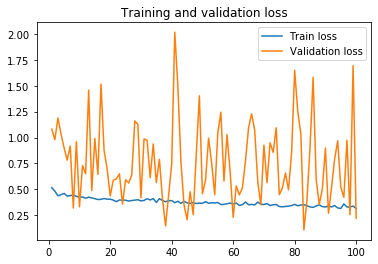

In [146]:
plt.plot(training_log['epoch'], training_log['train_loss'])
#plt.title("Loss on the training set over the epochs")
# plt.yticks(np.arange(0, 50, step = 5))
# plt.ylim(0,50)
#plt.show()

# Plotta accuracy över valideringsdatat:
plt.plot(training_log['epoch'], training_log['val_loss'])
plt.title("Training and validation loss")
#plt.yticks(np.arange(0, 1.1, step = 0.2))
#plt.ylim(0, max())
plt.legend(['Train loss', 'Validation loss'], loc = 'upper right')
plt.show()


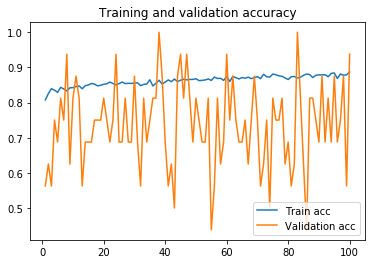

In [147]:
plt.plot(training_log['epoch'], training_log['train_acc'])
#plt.title("Loss on the training set over the epochs")
# plt.yticks(np.arange(0, 50, step = 5))
# plt.ylim(0,50)
#plt.show()

# Plotta accuracy över valideringsdatat:
plt.plot(training_log['epoch'], training_log['val_acc'])
plt.title("Training and validation accuracy")
#plt.yticks(np.arange(0, 1.1, step = 0.2))
#plt.ylim(0, max())
plt.legend(['Train acc', 'Validation acc'], loc = 'lower right')
plt.show()

In [148]:
max_train_acc = 100*max(training_log['train_acc'])

In [149]:
print(f'Max tränings-accuracy = {max_train_acc:.2f} %.')

Max tränings-accuracy = 88.71 %.


### Utvärdera modellen på validation- och test-set:

In [150]:
def evaluate_model(num_eval_images, data_loader, model):

    model.eval()

    start_eval_test_time = time.time()
    
    # Nedan för att vi inte ska uppdatera 
    # modellens vikter:

    with torch.no_grad():
        correct = 0
        # Antal iterationer = num_test_images / batchsz_test = x st.
    
        for X_test, y_test in data_loader:
            y_pred_test = model.forward(X_test)
            predicted = torch.max(input = y_pred_test, dim = 1)[1]
            correct += (predicted == y_test).sum()
    
        end_eval_test_time = time.time()
    
        eval_test_time = end_eval_test_time - start_eval_test_time

    print(f'Test accuracy: {correct.item()}/{num_eval_images} = {correct.item()*100/(num_eval_images):5.2f} %')
    print(f"\nEvaluation took {eval_test_time:.2f} seconds.")

In [151]:
num_test_images = len(test_loader.dataset)

evaluate_model(num_test_images, test_dl, model)

Test accuracy: 1478/2010 = 73.53 %

Evaluation took 8.72 seconds.


In [152]:
num_valid_images = len(valid_loader.dataset)

evaluate_model(num_valid_images, valid_dl, model)

Test accuracy: 762/998 = 76.35 %

Evaluation took 4.47 seconds.


### Confusion matrix

In [129]:
def pytorch_confusion_matrix(num_classes, model, dataloader):
    
    confusion_matrix = torch.zeros(num_classes, num_classes)
    
    with torch.no_grad():
        for i, (inputs, classes) in enumerate(dataloader):
            inputs = inputs.to(device)
            classes = classes.to(device)
            
            predictions = model.forward(inputs)
            _, preds = torch.max(predictions, 1)
            
            for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
    
    return confusion_matrix

In [130]:
# Beräkningen på test-setet tar ca. 24 sek.
# på den stationära datorn med GPU med 4 workers, 
# och ca. 19 sek. med 8 workers.

start_cm_time = time.time()
cm_test = pytorch_confusion_matrix(number_of_classes, model, test_dl)

end_cm_time = time.time()

delta_cm_time = end_cm_time - start_cm_time

print(f'Beräkningen av CM tog {delta_cm_time:.2f}.')

Beräkningen av CM tog 9.47.


In [131]:
# Spara confusion matrix till en fil...

cm_file_suffice = ".pt"
cm_filename = "results/" + file_name + cm_file_suffice
torch.save(cm_test, cm_filename)

In [132]:
# Ladda CM från en fil:

cm_test = torch.load(cm_filename)

In [133]:
cm_test_np = cm_test.numpy()

In [134]:
np.set_printoptions(suppress=True)
print(cm_test_np)

[[ 33.  14.   9.   4.   3.   3.   1.]
 [  7.  80.  10.   1.   1.   3.   2.]
 [  8.  11. 152.   4.  16.  23.   7.]
 [  0.   4.   3.  15.   0.   1.   1.]
 [  6.   4.  43.   6.  93.  61.  10.]
 [ 11.  36. 108.  37.  94. 976.  80.]
 [  0.   0.   0.   1.   1.   0.  27.]]


### Precision och recall (precision & sensitivitet):

In [135]:
# Beräkna första radens summa:
sum_row_one = np.sum(cm_test_np[:,0])

# Då blir t.ex. precision för label 1:
precision_label_one = cm_test_np[0][0].item() / sum_row_one

In [136]:
print(f'Precision för label 1 = {precision_label_one:.3f}')

Precision för label 1 = 0.508


In [137]:
# Motsvarande blir recall för label 1:

sum_col_1 = np.sum(cm_test_np[0,:])
recall_label_one = cm_test_np[0][0] / sum_col_1

print(f'Recall för label 1 = {recall_label_one:.3f}')

Recall för label 1 = 0.493


In [138]:
# Få ut labels så här:
test_loader.dataset.classes[0]

'akiec'

In [139]:
# Skapa en sammanställning över precision/recall för alla sju klasser.

# Precision:

print("Precision för respektive klass:")
for i in range(number_of_classes):
    sum_row_i = np.sum(cm_test_np[:, i])
    recall_i = cm_test_np[i,i] / sum_row_i
    print(f'{test_loader.dataset.classes[i]:5}: {recall_i:.3f}')


# Recall:

print("\nRecall för respektive klass:")
for j in range(number_of_classes):
    sum_col_j = np.sum(cm_test_np[j, :])
    recall_j = cm_test_np[j,j] / sum_col_j
    print(f'{test_loader.dataset.classes[j]:5}: {recall_j:.3f}')

Precision för respektive klass:
akiec: 0.508
bcc  : 0.537
bkl  : 0.468
df   : 0.221
mel  : 0.447
nv   : 0.915
vasc : 0.211

Recall för respektive klass:
akiec: 0.493
bcc  : 0.769
bkl  : 0.688
df   : 0.625
mel  : 0.417
nv   : 0.727
vasc : 0.931


### Visualisera modellens förutsägelser

In [ ]:
def visualize_model(model, num_images = 6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode = was_training)
                    return
        model.train(mode = was_training)

In [ ]:
visualize_model(model, 4)